In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/om-2022-ml-2-contest-2/1_data/train_data.csv')
print(df_train.shape)
df_train.head()

(1187461, 7)


,dist,due,f_class,lat,lon,s_class,t_class
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN


In [3]:
df_test = pd.read_csv('../input/om-2022-ml-2-contest-2/1_data/test_data.csv')
print(df_test.shape)
df_test.head()

(510937, 7)


,dist,due,f_class,lat,lon,s_class,t_class
0,4611.506701,2014-03-30 11:30:00.000,econom,55.776618,37.682503,NaN,NaN
1,14450.067441,2014-03-06 19:10:00.000,econom,55.754659,37.810072,NaN,NaN
2,17755.993723,2014-03-22 13:30:00.000,business,55.726141,37.587407,NaN,NaN
3,8533.172059,2014-03-22 05:10:00.000,econom,55.794178,37.576456,business,NaN
4,-1.000000,2014-03-12 19:15:00.000,econom,55.757409,37.542186,business,NaN


# Kmeans feature

Был прекрасный ноутбук с рамками городов, но я решил подойти к задаче группировки данных с другой стороны, то есть просто кластеризовать их)) Для начала построим несколько визуализаций.

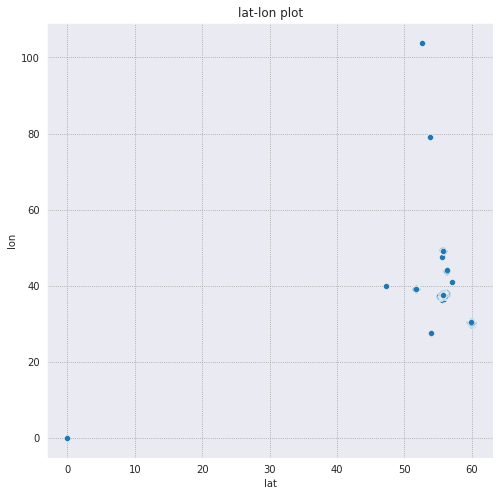

In [4]:
plt.figure(figsize=(8,8))

plt.title('lat-lon plot')
sns.scatterplot(x=df_train['lat'], y= df_train['lon'])

plt.show()

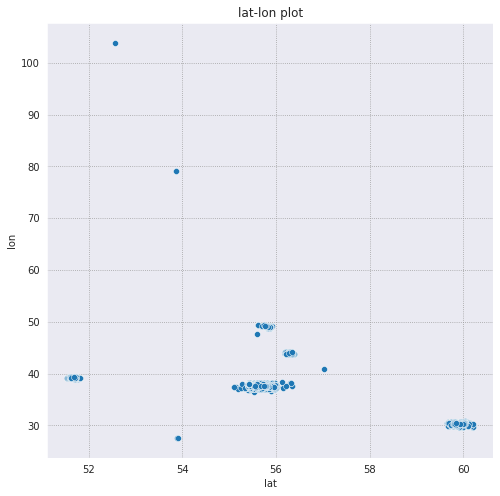

In [5]:
plt.figure(figsize=(8,8))

plt.title('lat-lon plot')
sns.scatterplot(x=df_train[df_train['lat'].between(50, 62)]['lat'], y= df_train['lon'])

plt.show()

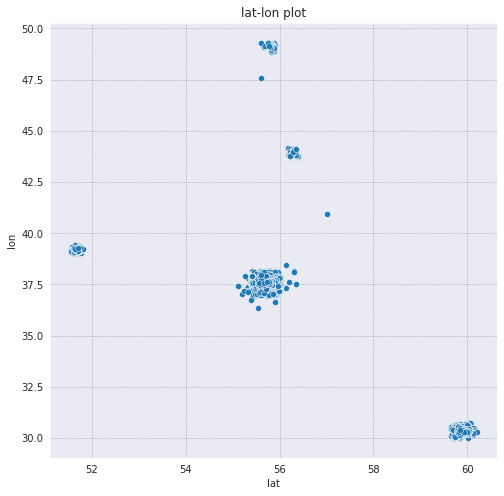

In [6]:
plt.figure(figsize=(8,8))

plt.title('lat-lon plot')
sns.scatterplot(x=df_train[df_train['lat'].between(50, 62)]['lat'], y= df_train[df_train['lon'].between(30, 50)]['lon'])

plt.show()

Собственно, я предлагаю ограничиться рамками последнего графика и кластеризовать данные алгоритмом Kmeans, используя широту и долготу как признаки. Все, что не попало в данные рамки, за счёт left join обратится в nan, а потом можно закодировать как отдельную категорию. Ниже реализована функция кластеризации.

In [7]:
from sklearn.cluster import KMeans

def get_lat_long_clusters(df_train, df_test, df_val=None):
    cols = list(df_train.columns)
    df_train_kmeans = df_train[df_train['lat'].between(50, 62) & df_train['lon'].between(30, 50)].copy()
    df_test_kmeans = df_test[df_test['lat'].between(50, 62) & df_test['lon'].between(30, 50)].copy()
    
    X_train = df_train_kmeans[['lat', 'lon']].copy().to_numpy()
    model = KMeans(n_clusters=5, random_state=42, init='k-means++')
    model.fit(X_train)
    df_train_kmeans['lat_long_cluster'] = model.labels_
    df_train_kmeans['lat_long_cluster'] = df_train_kmeans['lat_long_cluster'].astype(str)
    df_train_res = df_train.merge(df_train_kmeans, how='left', left_on=[pd.Int64Index(df_train.index)] + cols,\
                                  right_on=[pd.Int64Index(df_train_kmeans.index)] + cols, copy=True, indicator=False).set_index('key_0')
    
    X_test = df_test_kmeans[['lat', 'lon']].copy().to_numpy()
    df_test_kmeans['lat_long_cluster'] = model.predict(X_test)
    df_test_kmeans['lat_long_cluster'] = df_test_kmeans['lat_long_cluster'].astype(str)
    df_test_res = df_test.merge(df_test_kmeans, how='left', left_on=[pd.Int64Index(df_test.index)] + cols,\
                                  right_on=[pd.Int64Index(df_test_kmeans.index)] + cols,\
                                indicator=False, copy=True, ).set_index('key_0')
    
    if df_val is not None:
        df_val_kmeans = df_val[df_val['lat'].between(50, 62) & df_val['lon'].between(30, 50)].copy()
        X_val = df_val_kmeans[['lat', 'lon']].copy().to_numpy()
        df_val_kmeans['lat_long_cluster'] = model.predict(X_val)
        df_val_kmeans['lat_long_cluster'] = df_val_kmeans['lat_long_cluster'].astype(str)
        df_val_res = df_val.merge(df_val_kmeans, how='left', left_on=[df_val.index] + cols,\
                                 indicator=False, right_on=[df_val_kmeans.index] + cols, copy=True).set_index('key_0')
        
        return df_train_res, df_test_res, df_val_res
    
    return df_train_res, df_test_res

In [8]:
%%time

df_train, df_test = get_lat_long_clusters(df_train, df_test)

CPU times: user 20.2 s, sys: 6.88 s, total: 27.1 s
Wall time: 13.8 s


Посмотрим что получилось:

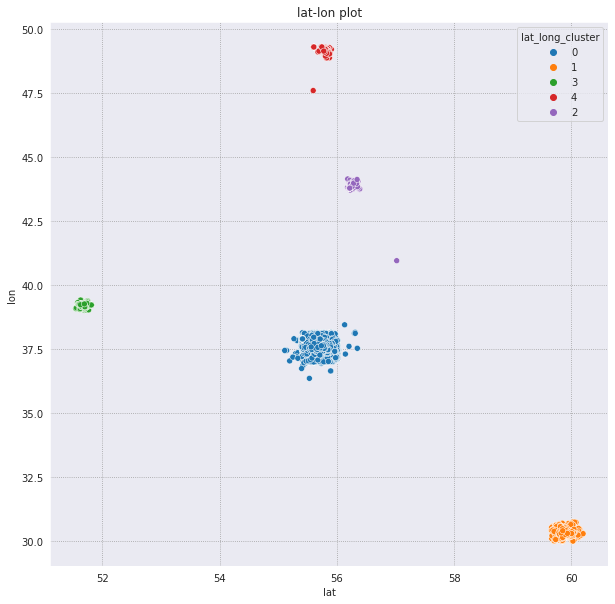

In [9]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=df_train['lat'], y= df_train['lon'], hue=df_train['lat_long_cluster'])

plt.show()

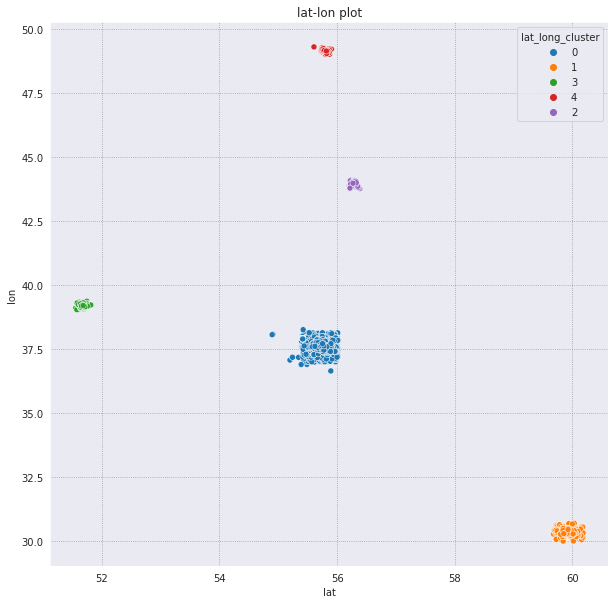

In [10]:
plt.figure(figsize=(10,10))

plt.title('lat-lon plot')
sns.scatterplot(x=df_test['lat'], y= df_test['lon'], hue=df_test['lat_long_cluster'])

plt.show()

Вроде ок, наны без перекодировки не отображаются. Вот и все)